# Adversarial Chess
6.4212 Final Project

Kameron Dawson

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder, StartMeshcat, Simulator, Rgba, RigidTransform
)
from pydrake.geometry import Sphere
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds, MakeMultibodyPlant
from manipulation.utils import RenderDiagram
from setup_simulation import get_scenario
from utils import visualize_box, visualize_text
from perception.point_cloud import get_model_point_clouds
from perception.perception import perception
from perception.bounding_box import orient_cloud
from motion.motion import TrajectoryController
from grasp.grasp import GraspController

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Setup meshcat for visualization
meshcat = StartMeshcat()
print('Click the link above to open Meshcat in your browser!')

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [3]:
# Clear meshcat
meshcat.Delete()

In [4]:
# Get scenario
scenario_string = get_scenario()

# Load the scenario and build the simulation station
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)

# Build a Drake Diagram containing the station
builder = DiagramBuilder()
builder.AddSystem(station)

# Setup getting point clouds from the cameras
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)
builder.ExportOutput(to_point_cloud['camera0'].get_output_port(), 'camera0_point_cloud')
builder.ExportOutput(to_point_cloud['camera1'].get_output_port(), 'camera1_point_cloud')
builder.ExportOutput(to_point_cloud['camera2'].get_output_port(), 'camera2_point_cloud')

# Make a plant including only the iiwa and gripper for the controllers
plant_iiwa1 = MakeMultibodyPlant(
    scenario=scenario, model_instance_names=['iiwa1', 'wsg1']
)
plant_iiwa2 = MakeMultibodyPlant(
    scenario=scenario, model_instance_names=['iiwa2', 'wsg2']
)

# Get their contexts
plant_context_iiwa1 = plant_iiwa1.CreateDefaultContext()
plant_context_iiwa2 = plant_iiwa2.CreateDefaultContext()

# Add controllers
iiwa1_traj_controller = builder.AddSystem(TrajectoryController(plant_iiwa1))
iiwa2_traj_controller = builder.AddSystem(TrajectoryController(plant_iiwa2))
iiwa1_grasp_controller = builder.AddSystem(GraspController(plant_iiwa1))
iiwa2_grasp_controller = builder.AddSystem(GraspController(plant_iiwa2))

# Connect ports
builder.Connect(iiwa1_traj_controller.GetOutputPort('q_desired'), station.GetInputPort('iiwa1.position'))
builder.Connect(iiwa2_traj_controller.GetOutputPort('q_desired'), station.GetInputPort('iiwa2.position'))
builder.Connect(iiwa1_grasp_controller.GetOutputPort('q_desired'), station.GetInputPort('wsg1.position'))
builder.Connect(iiwa2_grasp_controller.GetOutputPort('q_desired'), station.GetInputPort('wsg2.position'))

# Build diagram
diagram = builder.Build()

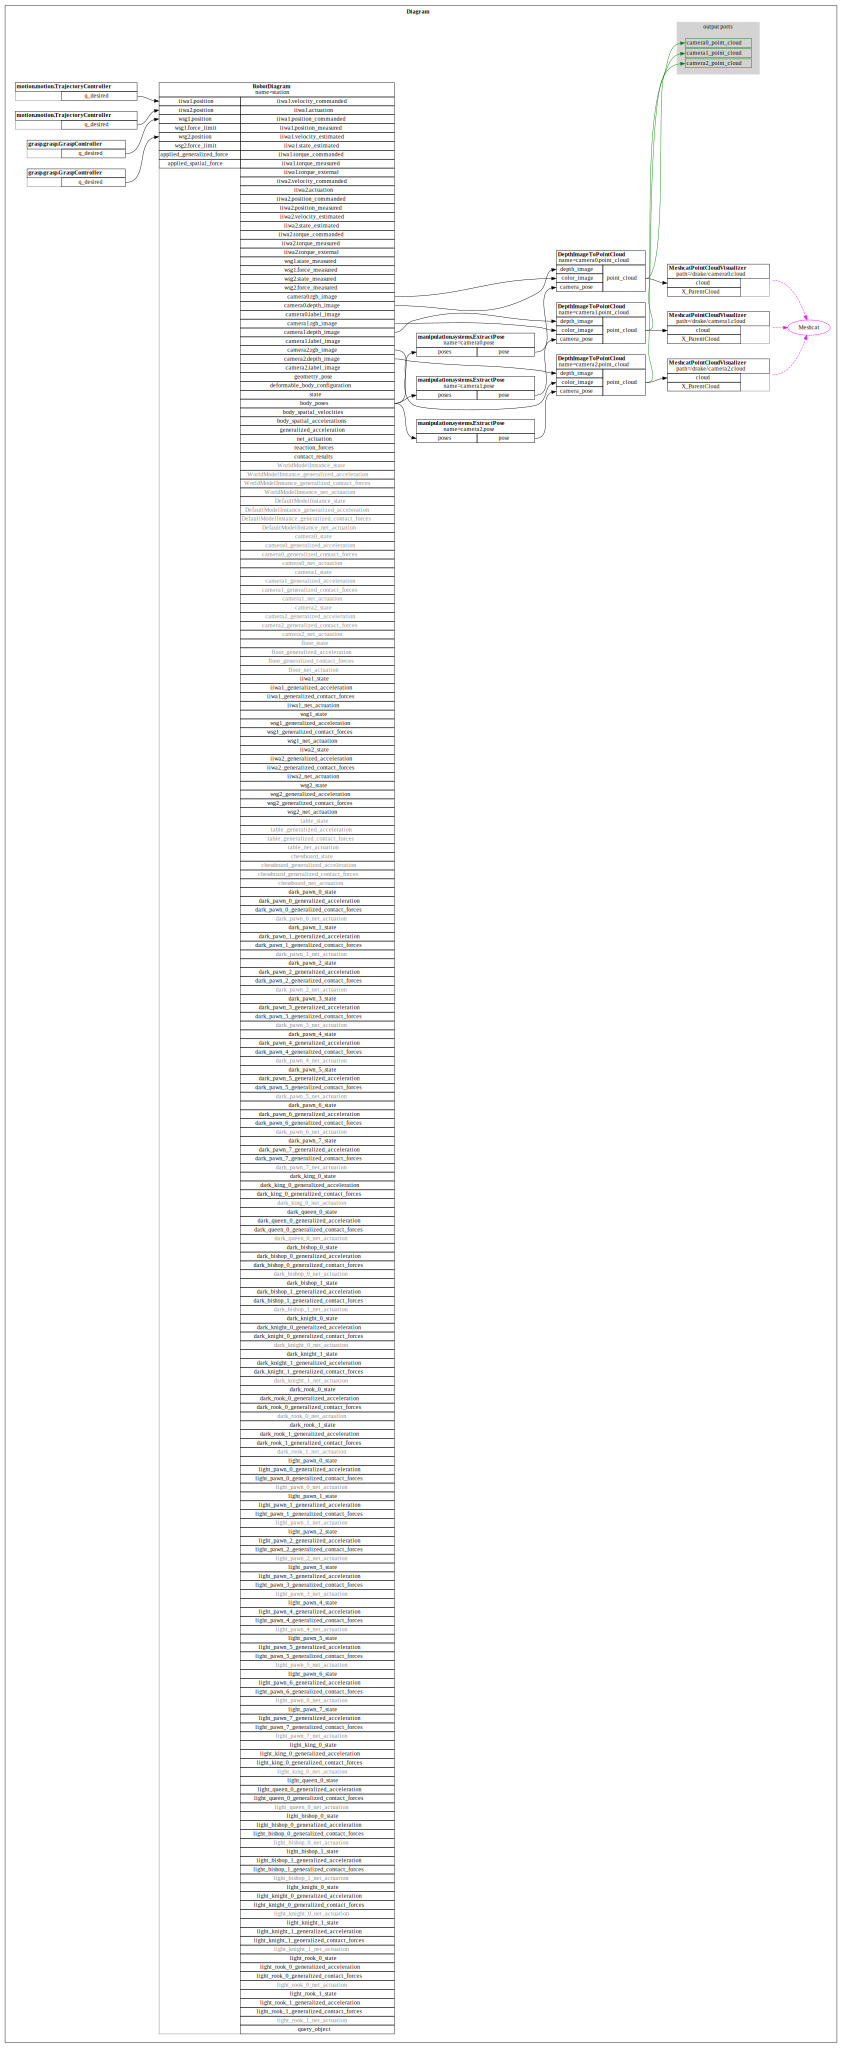

In [7]:
RenderDiagram(diagram, max_depth=1)

In [5]:
# Get relevant vars from the diagram, station
context = diagram.CreateDefaultContext()
plant = station.plant()
plant_context = diagram.GetSubsystemContext(plant, context)

In [9]:
# Create and run a simulator
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5)

KeyboardInterrupt: 

## Perception

### Sanity Check Cameras

In [ ]:
# Run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

In [ ]:
# Run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

### Sanity Check Perception

In [ ]:
# Get model point clouds
model_point_clouds = get_model_point_clouds()
model_piece_point_clouds = model_point_clouds['pieces']

# Orient the model piece point clouds
oriented_model_piece_point_clouds = {}
main_axis = np.array([0, 1, 0]) # models sits on their side in the y direction
for color, models in model_piece_point_clouds.items():
    oriented_model_piece_point_clouds[color] = {}
    for name, pc in models.items():
        oriented_pc = orient_cloud(pc, main_axis)
        oriented_model_piece_point_clouds[color][name] = oriented_pc

In [ ]:
# Get poses of every chess piece
perception_result = perception(diagram, context, oriented_model_piece_point_clouds, debugging=True)
piece_poses = perception_result['poses']

In [ ]:
# Visualize poses as sanity check
colors = {
    'pawn': Rgba(1, 0, 0), # red
    'king': Rgba(0, 1, 0), # green
    'queen': Rgba(0, 0, 1), # blue
    'bishop': Rgba(1, 1, 0), # yellow
    'knight': Rgba(0, 1, 1), # cyan
    'rook': Rgba(1, 0, 1) # magenta
}

for color in piece_poses:
    for piece in piece_poses[color]:
        for i, X in enumerate(piece_poses[color][piece]):
            path = f'/piece/{color}/{piece}{i}'
            meshcat.SetTransform(path, X)
            meshcat.SetObject(
                path, Sphere(0.01), rgba=colors[piece[:-1]]
            )

In [ ]:
# Visualize piece clouds
piece_pcs = perception_result['piece_pcs']
for color in piece_pcs:
    for piece in piece_pcs[color]:
        for i, pc in enumerate(piece_pcs[color][piece]):
            rgb = Rgba(1, 1, 1) if color == 'light' else Rgba(0, 0, 0)
            meshcat.SetObject(
                f'piece_pc_{color}_{piece}_{i}', pc, point_size=0.0025, rgba=rgb
            )

In [ ]:
# Visualize piece bounding boxes
for color in piece_pcs:
    for piece in piece_pcs[color]:
        for i, pc in enumerate(piece_pcs[color][piece]):
            pts = pc.xyzs()
            x, y, z = pts[0], pts[1], pts[2]
            min_x, max_x = np.min(x), np.max(x)
            min_y, max_y = np.min(y), np.max(y)
            min_z, max_z = np.min(z), np.max(z)
            lower, upper = np.array([min_x, min_y, min_z]), np.array([max_x, max_y, max_z])
            visualize_box(meshcat, lower, upper, f'piece_bb_{color}_{piece}_{i}')

## Motion Planning

In [ ]:
# Test transform above the table
pose1 = RigidTransform()
pose1.set_translation([0.0, 0.0, 0.7])
pose2 = RigidTransform()
pose2.set_translation([0.0, 0.0, 0.6])
poses = [pose1, pose2]

In [8]:
print("Plant input ports:")
for i in range(plant.num_input_ports()):
    print(i, plant.get_input_port(i).get_name())


Plant input ports:
0 geometry_query
1 actuation
2 applied_generalized_force
3 applied_spatial_force
4 WorldModelInstance_actuation
5 WorldModelInstance_desired_state
6 DefaultModelInstance_actuation
7 DefaultModelInstance_desired_state
8 camera0_actuation
9 camera0_desired_state
10 camera1_actuation
11 camera1_desired_state
12 camera2_actuation
13 camera2_desired_state
14 floor_actuation
15 floor_desired_state
16 iiwa1_actuation
17 iiwa1_desired_state
18 wsg1_actuation
19 wsg1_desired_state
20 iiwa2_actuation
21 iiwa2_desired_state
22 wsg2_actuation
23 wsg2_desired_state
24 table_actuation
25 table_desired_state
26 chessboard_actuation
27 chessboard_desired_state
28 dark_pawn_0_actuation
29 dark_pawn_0_desired_state
30 dark_pawn_1_actuation
31 dark_pawn_1_desired_state
32 dark_pawn_2_actuation
33 dark_pawn_2_desired_state
34 dark_pawn_3_actuation
35 dark_pawn_3_desired_state
36 dark_pawn_4_actuation
37 dark_pawn_4_desired_state
38 dark_pawn_5_actuation
39 dark_pawn_5_desired_state
40 d